In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-06-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)

np.save("data/btc_1m.npy", candles)

(2848320, 6)


In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles = candles[candles[:, 5] > 0]
print(candles.shape)
candles[0, 0]

(2861115, 6)


1577836800000.0

In [ ]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe
from joblib import Parallel, delayed

from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret_from_candles

df = numpy_candles_to_dataframe(candles)

# label
df["label"] = np.log(df["close"].shift(-1) / df["close"])

# high low range
df["hlr"] = np.log(df["high"] / df["low"])
# df["hlr_log"] = np.log(df["hlr"] + 1)
# df["hlr_sqrt"] = np.sqrt(df["hlr"] + 1) - 1

RANGE = [50, 100, 150]

# abs return
ret_list = []
for i in RANGE:
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list

# # log return
# log_list = []
# for i in RANGE:
#     log_series = np.log(df[f"r{i}"] + 1)
#     log_series.name = f"r{i}_log"
#     log_list.append(log_series)
#
# # sqrt return
# sqrt_list = []
# for i in RANGE:
#     sqrt_series = np.sqrt(df[f"r{i}"] + 1) - 1
#     sqrt_series.name = f"r{i}_sqrt"
#     sqrt_list.append(sqrt_series)

# entropy
entropy_list = []
for i in RANGE:
    log_ret_list = log_ret_from_candles(candles, [i] * len(candles))
    entropy_array = Parallel(n_jobs=-1)(
        delayed(sample_entropy_numba)(i) for i in log_ret_list
    )
    len_gap = len(df) - len(entropy_array)

    entropy_array = [np.nan] * len_gap + entropy_array
    entropy_series = pd.Series(entropy_array, index=df.index)
    entropy_series.name = f"r{i}_entropy"
    entropy_list.append(entropy_series)

    entropy_inv = 1 / np.asarray(entropy_array)
    entropy_inv_series = pd.Series(entropy_inv, index=df.index)
    entropy_inv_series.name = f"r{i}_entropy_inv"
    entropy_list.append(entropy_inv_series)

df = pd.concat(
    [
        df,
        # pd.concat(log_list, axis=1),
        # pd.concat(sqrt_list, axis=1),
        pd.concat(entropy_list, axis=1),
    ],
    axis=1,
)
del entropy_list

In [4]:
# data cleaning
na_max = df.isna().sum().max()
df = df.iloc[na_max:]
del candles
print(df.shape)

print(df.isna().sum().max())
df.head()

(2860965, 17)
1


,date,open,close,high,low,volume,label,hlr,r50,r100,r150,r50_entropy,r50_entropy_inv,r100_entropy,r100_entropy_inv,r150_entropy,r150_entropy_inv
2020-01-01 02:30:00,2020-01-01 02:30:00,7221.59,7227.00,7227.79,7221.59,82.247,-0.000018,0.000858,0.001881,0.006817,0.006185,0.168884,5.921227,0.055175,18.124190,0.034509,28.977999
2020-01-01 02:31:00,2020-01-01 02:31:00,7226.96,7226.87,7227.73,7223.93,118.737,-0.000143,0.000526,0.002552,0.006983,0.006645,0.172914,5.783217,0.057110,17.509947,0.035480,28.185215
2020-01-01 02:32:00,2020-01-01 02:32:00,7226.06,7225.84,7226.13,7224.90,53.181,0.000195,0.000170,0.002591,0.007356,0.006652,0.185109,5.402230,0.061849,16.168316,0.037777,26.471342
2020-01-01 02:33:00,2020-01-01 02:33:00,7225.97,7227.25,7230.17,7224.78,100.884,0.000159,0.000746,0.002831,0.007484,0.006405,0.193260,5.174381,0.061849,16.168316,0.038144,26.216209
2020-01-01 02:34:00,2020-01-01 02:34:00,7226.88,7228.40,7228.44,7224.80,67.185,0.000112,0.000504,0.003016,0.007731,0.007380,0.168846,5.922556,0.063480,15.752988,0.039290,25.451726


In [5]:
data_check = np.load("data/btc_1m.npy")
data_check = data_check[data_check[:, 5] > 0]
# hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
# r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[150:]
# hlr_check = hlr_check[149:]
# r1_check = r1_check[149 - 1 :]

# data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [5]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)

In [6]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [ ]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from jesse.helpers import date_to_timestamp
from scipy import stats

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum


def get_kurtosis(merged_bar):
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[5:] / close_arr[:-5])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    candles_in_metrics = candles_in_metrics[candles_in_metrics[:, 5] > 0]
    # h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    # r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[150:]
    # h1r = h1r[149:]
    # r1 = r1[149 - 1 :]
    # candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )

    cumsum_threshold = np.sum(y_pred) / (len(candles_in_metrics) // 120)

    merged_bar_cumsum = build_bar_by_cumsum(
        candles_in_metrics,
        y_pred,
        cumsum_threshold,
        reverse=False,
    )
    kurtosis_cumsum = get_kurtosis(merged_bar_cumsum)
    if len(merged_bar_cumsum) < len(candles_in_metrics) // 180:
        return 1000

    merged_bar_2023 = merged_bar_cumsum[
        (merged_bar_cumsum[:, 0] >= date_to_timestamp("2023-01-01"))
        & (merged_bar_cumsum[:, 0] <= date_to_timestamp("2023-12-31"))
    ]
    kurtosis_2023 = get_kurtosis(merged_bar_2023)

    merged_bar_2024 = merged_bar_cumsum[
        (merged_bar_cumsum[:, 0] >= date_to_timestamp("2024-01-01"))
        & (merged_bar_cumsum[:, 0] <= date_to_timestamp("2024-12-31"))
    ]
    kurtosis_2024 = get_kurtosis(merged_bar_2024)

    merged_bar_2025 = merged_bar_cumsum[
        (merged_bar_cumsum[:, 0] >= date_to_timestamp("2025-01-01"))
        & (merged_bar_cumsum[:, 0] <= date_to_timestamp("2025-12-31"))
    ]
    kurtosis_2025 = get_kurtosis(merged_bar_2025)

    kurtosis_list = [kurtosis_cumsum, kurtosis_2023, kurtosis_2024, kurtosis_2025]
    kurtosis_list = [kurtosis for kurtosis in kurtosis_list if not np.isnan(kurtosis)]

    if len(kurtosis_list) == 0:
        return 1000
    return np.max(kurtosis_list)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = ["hlr"] + [f"r{i}" for i in RANGE] + [f"r{i}_entropy" for i in RANGE[2:]]

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=20000,
    generations=30,
    tournament_size=50,
    stopping_criteria=2,
    function_set=["add", "sub", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.12,
    p_hoist_mutation=0.06,
    p_point_mutation=0.12,
    max_samples=1,
    parsimony_coefficient=0.009,
    feature_names=cols,
    verbose=1,
    n_jobs=12,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.39          152.931       15          5.26533              N/A    278.72m
   1    13.97          101.132       15          5.26533              N/A    220.80m
   2    23.80          91.1534       17           4.9831              N/A    236.56m
   3    23.25          115.344       42          4.65894              N/A    238.31m
   4    16.72          145.786       40           4.6274              N/A    226.38m


KeyboardInterrupt: 

In [8]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 6:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res

,fitness,len,program
1,5.905118,38,"min(abs(r150), add(r150_entropy, r50))"
264,5.905118,38,"min(abs(r150), add(r50, r150_entropy))"
688,5.346329,48,"neg(max(neg(hlr), sub(-0.179, add(r150, r100))))"
351,5.923118,48,"neg(neg(min(abs(r150), add(r150_entropy, r50))))"
170,5.971712,48,"min(add(abs(sub(-0.014, 0.083)), r50), abs(hlr))"
...,...,...,...
6888,5.469012,333,"min(neg(min(max(min(neg(hlr), max(hlr, r150_en..."
85,5.721483,335,"neg(max(min(neg(hlr), min(add(max(add(add(add(..."
8113,5.470672,343,"min(neg(min(max(min(neg(hlr), max(hlr, r150_en..."
7002,5.478012,346,"min(neg(min(max(min(neg(hlr), max(hlr, r150_en..."


In [9]:
counter = 0
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")
    counter += 1
    if counter > 100:
        break

fitness = 5.905118433207158: min(abs(r150), add(r150_entropy, r50))
fitness = 5.905118433207158: min(abs(r150), add(r50, r150_entropy))
fitness = 5.346328527318275: neg(max(neg(hlr), sub(-0.179, add(r150, r100))))
fitness = 5.923118433207158: neg(neg(min(abs(r150), add(r150_entropy, r50))))
fitness = 5.971711604105172: min(add(abs(sub(-0.014, 0.083)), r50), abs(hlr))
fitness = 5.9807116041051716: min(add(abs(sub(-0.014, 0.083)), r50), abs(neg(hlr)))
fitness = 5.364328527318275: neg(max(neg(hlr), sub(min(hlr, -0.179), add(r150, r100))))
fitness = 5.364328527318275: neg(max(min(neg(hlr), hlr), sub(-0.179, add(r150, r100))))
fitness = 5.586566742529011: neg(max(neg(hlr), sub(min(r150, -0.179), add(r150, r100))))
fitness = 5.63543742778733: neg(max(neg(hlr), sub(min(r100, -0.179), add(r150, r100))))
fitness = 5.364328527318275: neg(max(neg(hlr), sub(min(0.543, -0.179), add(r150, r100))))
fitness = 5.364328527318275: neg(max(neg(hlr), sub(min(0.800, -0.179), add(r150, r100))))
fitness = 5.9

In [2]:
"""
min(abs(r25), add(r100, r50_entropy))
min(abs(r50), max(r75_entropy, r100_entropy))
abs(min(max(r100, r25_entropy), abs(r10)))
min(abs(r25), max(r10, r100_entropy))
min(abs(r75), add(r5, r75_entropy))

max(min(hlr, r150_entropy), min(abs(r25), abs(r75)))

sub(hlr, min(add(r75_entropy, r10), hlr))
"""

import numpy as np
import pandas as pd
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe

from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret_from_candles

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-06-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles = candles[candles[:, 5] > 0]

print(candles.shape)

# hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
# r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
# candles = candles[1:]

# candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles)
df["hlr"] = np.log(df["high"] / df["low"])
df["r10"] = np.log(df["close"] / df["close"].shift(10))
log_ret_list = log_ret_from_candles(candles, 75)
entropy_array = Parallel(n_jobs=-1)(
    delayed(sample_entropy_numba)(i) for i in log_ret_list
)

len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df["r75_entropy"] = entropy_array

df["threshold"] = df["hlr"] - pd.concat(
    [df["r75_entropy"] + df["r10"], df["hlr"]], axis=1
).min(axis=1)

na_max = df.isna().sum().max()
df = df.iloc[na_max:]
print(df.shape)
df.head()

(2848155, 6)
(2848080, 10)


,date,open,close,high,low,volume,hlr,r10,r75_entropy,threshold
2020-01-01 01:15:00,2020-01-01 01:15:00,7186.60,7186.02,7186.60,7184.16,27.591,0.000340,0.000884,0.168780,0.0
2020-01-01 01:16:00,2020-01-01 01:16:00,7186.47,7186.00,7187.36,7186.00,9.914,0.000189,0.000367,0.167888,0.0
2020-01-01 01:17:00,2020-01-01 01:17:00,7186.00,7186.00,7186.00,7185.99,5.470,0.000001,0.000090,0.156191,0.0
2020-01-01 01:18:00,2020-01-01 01:18:00,7186.00,7186.00,7186.00,7185.99,2.941,0.000001,-0.000111,0.154512,0.0
2020-01-01 01:19:00,2020-01-01 01:19:00,7186.00,7187.64,7187.64,7185.99,15.078,0.000230,0.000367,0.154876,0.0


In [3]:
df["threshold"].sum() / (len(candles) // 60)

0.0004161412668441069

In [4]:
df.tail()

,date,open,close,high,low,volume,hlr,r10,r75_entropy,threshold
2025-05-31 23:55:00,2025-05-31 23:55:00,104558.4,104556.8,104562.8,104552.2,22.175,0.000101,-0.000391,0.122796,0.0
2025-05-31 23:56:00,2025-05-31 23:56:00,104556.8,104552.3,104556.9,104552.2,7.509,0.000045,-0.000109,0.122748,0.0
2025-05-31 23:57:00,2025-05-31 23:57:00,104552.2,104536.4,104552.3,104536.3,12.238,0.000153,-0.000130,0.123481,0.0
2025-05-31 23:58:00,2025-05-31 23:58:00,104536.3,104544.8,104544.9,104536.3,15.783,0.000082,-0.000347,0.123584,0.0
2025-05-31 23:59:00,2025-05-31 23:59:00,104544.8,104544.7,104544.9,104536.3,16.743,0.000082,-0.000645,0.120337,0.0


In [5]:
len(candles) - len(df)

75

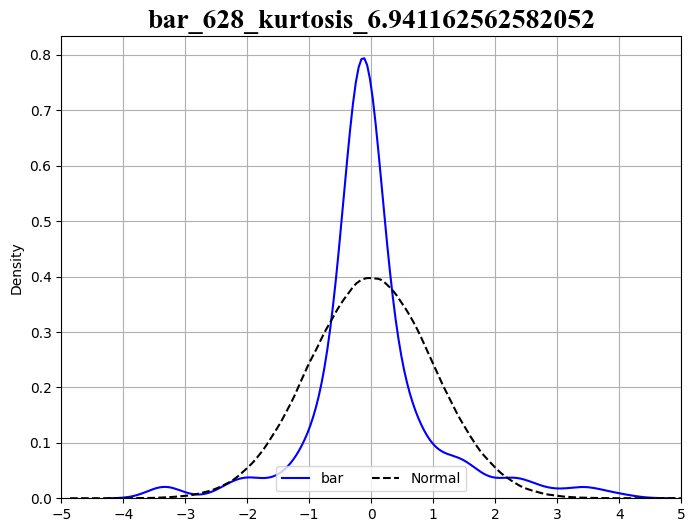

In [8]:
from custom_indicators.utils.plot import plot_kde

assert len(candles[75:]) == len(df)

"""
threshold:
0.7907317146647048
0.916133494307828
"""

merged_bar = build_bar_by_cumsum(
    candles[150:], df["threshold"].tolist(), 0.0004161412668441069, reverse=False
)

plot_kde(merged_bar[:, 2], lag=5)

In [2]:
import numpy as np
import optuna
import pandas as pd
from jesse.helpers import date_to_timestamp  # noqa
from jesse.utils import numpy_candles_to_dataframe
from scipy import stats  # noqa

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret_from_candles

# 尝试进一步迭代


def get_kurtosis(merged_bar):
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[5:] / close_arr[:-5])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    df = numpy_candles_to_dataframe(candles)
    log_n_1 = trial.suggest_int("log_n_1", 1, 200)
    df[f"r{log_n_1}"] = np.log(df["close"] / df["close"].shift(log_n_1))
    log_n_2 = trial.suggest_int("log_n_2", 1, 200)
    df[f"r{log_n_2}"] = np.log(df["close"] / df["close"].shift(log_n_2))

    # entropy
    entropy_n = trial.suggest_int("entropy_n", 30, 200)
    log_ret_list = log_ret_from_candles(candles, [entropy_n] * len(candles))
    with WorkerPool() as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    df[f"en_{entropy_n}"] = entropy_array

    na_max = df.isna().sum().max()
    df = df.iloc[na_max:]

    df["threshold"] = pd.concat(
        [
            df[f"r{log_n_1}"].abs(),
            df[f"r{log_n_2}"] + df[f"en_{entropy_n}"],
        ],
        axis=1,
    ).min(axis=1)

    threshold_min = df["threshold"].sum() / (len(candles) // 30)
    threshold_max = df["threshold"].sum() / (len(candles) // 240)
    threshold = trial.suggest_float("threshold", threshold_min, threshold_max)

    len_gap = len(candles) - len(df)
    candles = candles[len_gap:]
    assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
    merged_bar = build_bar_by_cumsum(
        candles, df["threshold"].tolist(), threshold, reverse=False
    )

    # kurtosis
    kurtosis_all = get_kurtosis(merged_bar)
    kurtosis_2023 = get_kurtosis(
        merged_bar[
            (date_to_timestamp("2022-06-01") <= merged_bar[:, 0])
            & (merged_bar[:, 0] <= date_to_timestamp("2023-06-01"))
        ]
    )
    kurtosis_2024 = get_kurtosis(
        merged_bar[
            (date_to_timestamp("2023-06-01") <= merged_bar[:, 0])
            & (merged_bar[:, 0] <= date_to_timestamp("2024-06-01"))
        ]
    )
    kurtosis_2025 = get_kurtosis(
        merged_bar[
            (date_to_timestamp("2024-06-01") <= merged_bar[:, 0])
            & (merged_bar[:, 0] <= date_to_timestamp("2025-06-01"))
        ]
    )
    final_kurtosis = (kurtosis_all + kurtosis_2023 + kurtosis_2024 + kurtosis_2025) / 4

    return final_kurtosis


"""
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource='auto',
        reduction_factor=2,  # 从默认的3降低到2，保留更多试验
        bootstrap_count=10   # 增加启动试验数，让更多试验有机会展示潜力
    ),
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=150,  # 增加启动试验数，增强初期探索
        n_ei_candidates=50,    # 增加候选点数量，提高探索能力
        multivariate=True      # 考虑参数间的相关性
    ),
)

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.PercentilePruner(
        percentile=25.0,      # 只剪枝表现在后25%的试验
        n_startup_trials=50,  # 前50个试验不剪枝
        n_warmup_steps=20     # 每个试验前20步不剪枝
    ),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
"""
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.PercentilePruner(
        percentile=25.0,
        n_startup_trials=50,  # 前50个试验不剪枝
        n_warmup_steps=20,  # 每个试验前20步不剪枝
    ),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=1000, n_jobs=1, gc_after_trial=True)

[I 2025-06-07 09:07:26,763] A new study created in memory with name: no-name-02cd0927-2e8c-4be3-ac4f-740ce711f9db
[I 2025-06-07 09:08:29,184] Trial 0 finished with value: 20.344105980573655 and parameters: {'log_n_1': 2, 'log_n_2': 23, 'entropy_n': 163, 'threshold': 0.03341882088958513}. Best is trial 0 with value: 20.344105980573655.
[I 2025-06-07 09:09:24,118] Trial 1 finished with value: 4.97420864140844 and parameters: {'log_n_1': 114, 'log_n_2': 57, 'entropy_n': 98, 'threshold': 0.5242026554376439}. Best is trial 1 with value: 4.97420864140844.
[I 2025-06-07 09:10:12,962] Trial 2 finished with value: 4.4991004167531425 and parameters: {'log_n_1': 62, 'log_n_2': 71, 'entropy_n': 41, 'threshold': 0.655238747424979}. Best is trial 2 with value: 4.4991004167531425.
[I 2025-06-07 09:11:03,676] Trial 3 finished with value: 4.742337219196686 and parameters: {'log_n_1': 24, 'log_n_2': 132, 'entropy_n': 59, 'threshold': 0.4406542289127281}. Best is trial 2 with value: 4.4991004167531425.
[

KeyboardInterrupt: 

In [4]:
study.best_params

{'log_n_1': 200,
 'log_n_2': 135,
 'entropy_n': 59,
 'threshold': 1.7845846084900419}

In [ ]:
"""
min(abs(short_log_n), add(long_log_n, rn_entropy))
{'short_log_n': 21,
 'long_log_n': 180,
 'rn_entropy': 34,
 'threshold': 0.8548507667918396}

min(abs(log_n_1), add(log_n_2, rn_entropy))
{'log_n_1': 200,
 'log_n_2': 135,
 'entropy_n': 59,
 'threshold': 1.7845846084900419}
"""

(2848320, 6)
0.5104635883587778


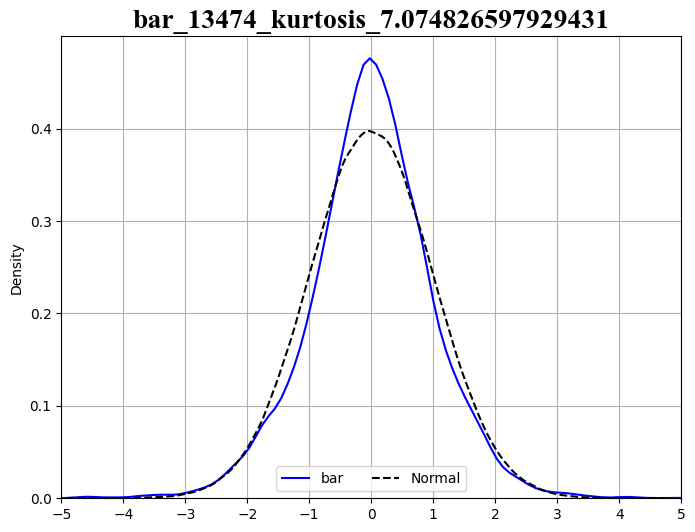

In [ ]:
import numpy as np
import pandas as pd
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe
from joblib import Parallel, delayed

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret_from_candles

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-06-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
print(candles.shape)
candles = candles[candles[:, 5] > 0]
df = numpy_candles_to_dataframe(candles)
# short log ret
short_log_n = 21
df[f"r{short_log_n}"] = np.log(df["close"] / df["close"].shift(short_log_n))

# long log ret
long_log_n = 180
df[f"r{long_log_n}"] = np.log(df["close"] / df["close"].shift(long_log_n))

# entropy
entropy_n = 34
log_ret_list = log_ret_from_candles(candles, entropy_n)
entropy_array = Parallel(n_jobs=-1)(
    delayed(sample_entropy_numba)(i) for i in log_ret_list
)

len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df[f"en_{entropy_n}"] = entropy_array

na_max = df.isna().sum().max()
df = df.iloc[na_max:]

df["threshold"] = pd.concat(
    [
        df[f"r{short_log_n}"].abs(),
        df[f"r{long_log_n}"] + df[f"en_{entropy_n}"],
    ],
    axis=1,
).min(axis=1)

len_gap = len(candles) - len(df)
candles = candles[len_gap:]

threshold = df["threshold"].sum() / (len(candles) // 210)
print(threshold)

assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
merged_bar = build_bar_by_cumsum(
    candles, df["threshold"].tolist(), threshold, reverse=False
)

from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2])

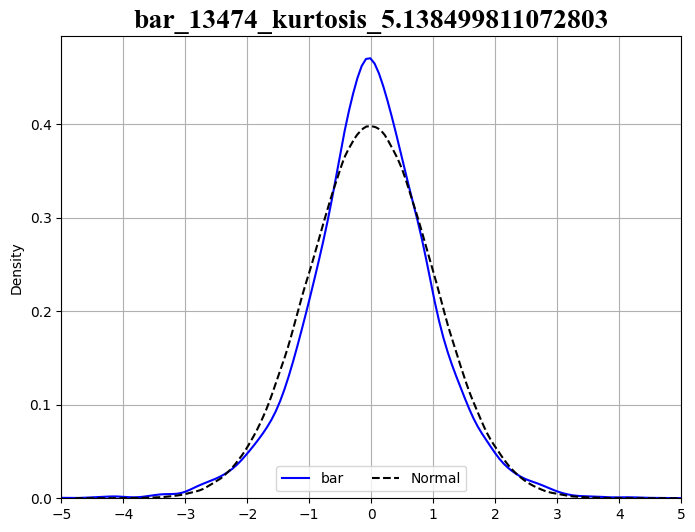

In [11]:
plot_kde(merged_bar[:, 2], lag=5)

In [26]:
df["threshold"]

2020-01-01 03:34:00    0.002127
2020-01-01 03:35:00    0.001942
2020-01-01 03:36:00    0.000540
2020-01-01 03:37:00    0.000082
2020-01-01 03:38:00    0.001046
                         ...   
2025-05-30 23:55:00    0.002473
2025-05-30 23:56:00    0.003039
2025-05-30 23:57:00    0.000402
2025-05-30 23:58:00    0.001216
2025-05-30 23:59:00    0.002361
Name: threshold, Length: 2846501, dtype: float64

In [37]:
(df["threshold"].iloc[180:] - thresholds).sum()

0.0

In [18]:
df["close"]

2020-01-01 03:34:00      7238.46
2020-01-01 03:35:00      7236.59
2020-01-01 03:36:00      7227.47
2020-01-01 03:37:00      7224.86
2020-01-01 03:38:00      7222.34
                         ...    
2025-05-30 23:55:00    103999.00
2025-05-30 23:56:00    103992.60
2025-05-30 23:57:00    103915.90
2025-05-30 23:58:00    103932.90
2025-05-30 23:59:00    103950.00
Name: close, Length: 2846501, dtype: float64

In [17]:
df["r21"]

2020-01-01 03:34:00    0.002127
2020-01-01 03:35:00    0.001942
2020-01-01 03:36:00    0.000540
2020-01-01 03:37:00    0.000082
2020-01-01 03:38:00   -0.001046
                         ...   
2025-05-30 23:55:00    0.002473
2025-05-30 23:56:00    0.003039
2025-05-30 23:57:00    0.000402
2025-05-30 23:58:00    0.001216
2025-05-30 23:59:00    0.002361
Name: r21, Length: 2846501, dtype: float64

In [16]:
log_ret_short_n = np.log(candles[21:, 2] / candles[:-21, 2])[180 - 21 :]
log_ret_short_n[0]

6.228567673667354e-05

In [1]:
import numpy as np
from jesse import helpers, research

candles = np.load("data/btc_1m.npy")
candles.shape

(2831040, 6)

In [2]:
from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret_from_candles

SHORT_N = 21
LONG_N = 180
ENTROPY_N = 34
THRESHOLD = 0.8548507667918396

_unfinished_bars_timestamps = None
_unfinished_bars_thresholds = None
_merged_bars = None


def get_thresholds(candles_: np.ndarray) -> np.ndarray:
    log_ret_short_n = np.log(candles_[SHORT_N:, 2] / candles_[:-SHORT_N, 2])[
        LONG_N - SHORT_N :
    ]

    log_ret_long_n = np.log(candles_[LONG_N:, 2] / candles_[:-LONG_N, 2])
    entropy_log_ret_list = log_ret_from_candles(
        candles_[LONG_N - ENTROPY_N :, :], ENTROPY_N
    )
    entropy_array = Parallel(n_jobs=-1)(
        delayed(sample_entropy_numba)(i) for i in entropy_log_ret_list
    )
    del entropy_log_ret_list

    return np.min([np.abs(log_ret_short_n), log_ret_long_n + entropy_array], axis=0)


# 初始化
init_candles = candles[candles[:, 5] > 0][:-10000]
thresholds = get_thresholds(init_candles)
init_candles = init_candles[len(init_candles) - len(thresholds) :]
_merged_bars = build_bar_by_cumsum(candles, thresholds, THRESHOLD, reverse=False)

_unfinished_bars_timestamps = init_candles[:, 0].astype(int)[
    init_candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
]
_unfinished_bars_thresholds = thresholds[
    init_candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
]

In [7]:
update_candles = candles[:-9999]
anchor_index_array = np.where(
    candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
)[0]
anchor_index = anchor_index_array[0] - LONG_N
update_candles = update_candles[anchor_index:]
update_thresholds = get_thresholds(update_candles)
all_thresholds = np.hstack([_unfinished_bars_thresholds, update_thresholds])
len(all_thresholds)

1423

In [10]:
all_unfinished_candles = candles[:-9999][
    candles[:-9999][:, 0].astype(int) > _unfinished_bars_timestamps[0]
]
all_unfinished_candles.shape

(711, 6)